#Initial Setup

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Advanced ML libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_recall_fscore_support, roc_auc_score)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# For feature importance and model interpretation
from sklearn.inspection import permutation_importance
import joblib


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load & Inspect Dataset

In [48]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/Avocado Ripeness Classification Dataset/avocado_ripeness_dataset.csv')


In [49]:
df.describe()

,firmness,hue,saturation,brightness,sound_db,weight_g,size_cm3
count,250.000000,250.00000,250.000000,250.00000,250.000000,250.000000,250.000000
mean,50.618400,125.94400,64.356000,45.07200,58.016000,220.188000,208.644000
std,27.277678,117.13767,17.377144,19.11629,13.838126,34.405225,55.940564
min,10.300000,1.00000,30.000000,10.00000,30.000000,152.000000,100.000000
25%,25.750000,25.25000,51.250000,31.00000,47.250000,193.250000,155.250000
50%,48.950000,77.00000,65.000000,46.00000,60.000000,220.000000,218.000000
75%,74.050000,278.75000,76.750000,58.00000,68.000000,245.000000,260.500000
max,98.800000,329.00000,99.000000,78.00000,79.000000,299.000000,299.000000


In [50]:
print("="*60)
print("🥑 AVOCADO RIPENESS PREDICTION PROJECT")
print("="*60)
print(f"Dataset shape: {df.shape}")
print("\nDataset Info:")
print(df.info())
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nDataset head:\n{df.head()}")

🥑 AVOCADO RIPENESS PREDICTION PROJECT
Dataset shape: (250, 9)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   firmness        250 non-null    float64
 1   hue             250 non-null    int64  
 2   saturation      250 non-null    int64  
 3   brightness      250 non-null    int64  
 4   color_category  250 non-null    object 
 5   sound_db        250 non-null    int64  
 6   weight_g        250 non-null    int64  
 7   size_cm3        250 non-null    int64  
 8   ripeness        250 non-null    object 
dtypes: float64(1), int64(6), object(2)
memory usage: 17.7+ KB
None

Missing values:
firmness          0
hue               0
saturation        0
brightness        0
color_category    0
sound_db          0
weight_g          0
size_cm3          0
ripeness          0
dtype: int64

Dataset head:
   firmness  hue  saturation  b

#EXPLORATORY DATA ANALYIS

In [51]:
print("\n" + "="*60)
print("📊 EXPLORATORY DATA ANALYSIS")
print("="*60)


# Check target distribution
print(f"\nRipeness distribution:")
ripeness_counts = df['ripeness'].value_counts()
print(ripeness_counts)
print(f"\nRipeness percentages:")
print(df['ripeness'].value_counts(normalize=True) * 100)

# Check for class imbalance
print(f"\nClass imbalance ratio: {ripeness_counts.max() / ripeness_counts.min():.2f}")

# Color category distribution
if 'color_category' in df.columns:
    print(f"\nColor category distribution:")
    print(df['color_category'].value_counts())



📊 EXPLORATORY DATA ANALYSIS

Ripeness distribution:
ripeness
ripe               50
pre-conditioned    50
hard               50
breaking           50
firm-ripe          50
Name: count, dtype: int64

Ripeness percentages:
ripeness
ripe               20.0
pre-conditioned    20.0
hard               20.0
breaking           20.0
firm-ripe          20.0
Name: proportion, dtype: float64

Class imbalance ratio: 1.00

Color category distribution:
color_category
black         75
purple        75
green         50
dark green    50
Name: count, dtype: int64


In [52]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Text(0, 0.5, 'Frequency')

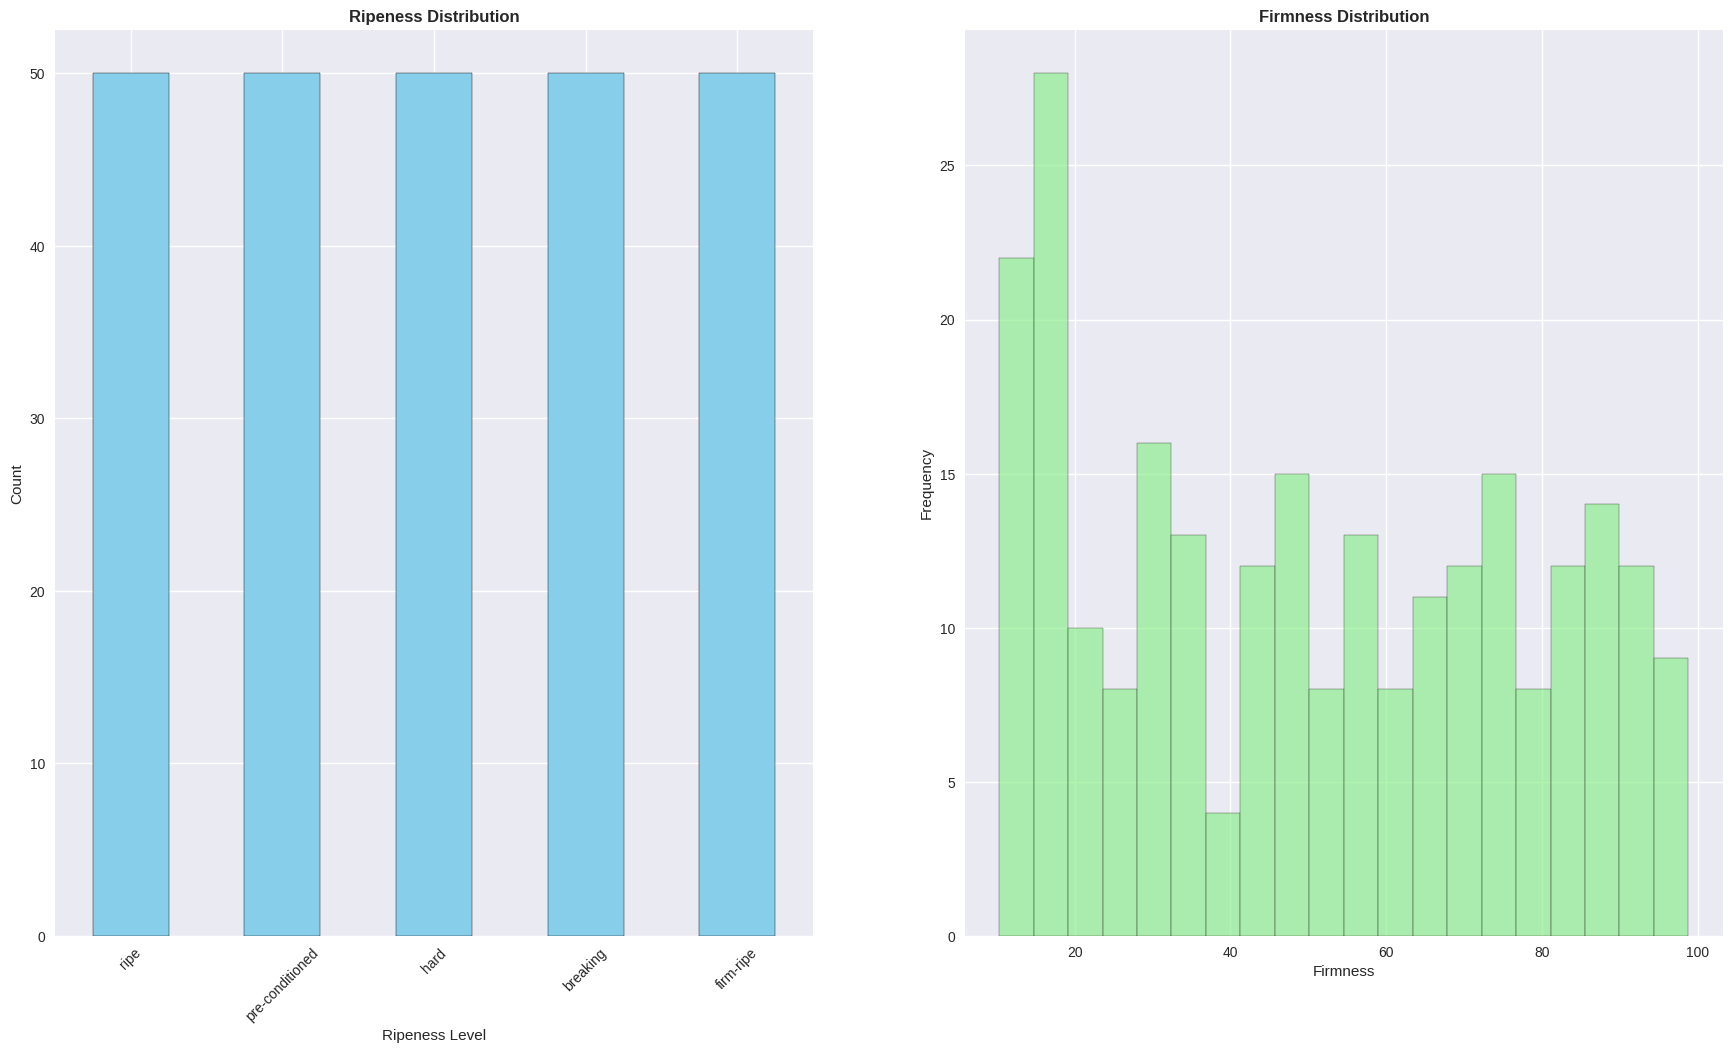

In [53]:
fig = plt.figure(figsize=(45,40))  # Wider and taller
# Subplot 1: Target distribution
plt.subplot(3, 4, 1)
df['ripeness'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Ripeness Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Ripeness Level')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Subplot 2: Firmness distribution
plt.subplot(3, 4, 2)
plt.hist(df['firmness'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Firmness Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Firmness')
plt.ylabel('Frequency')



Text(0, 0.5, 'Sound (dB)')

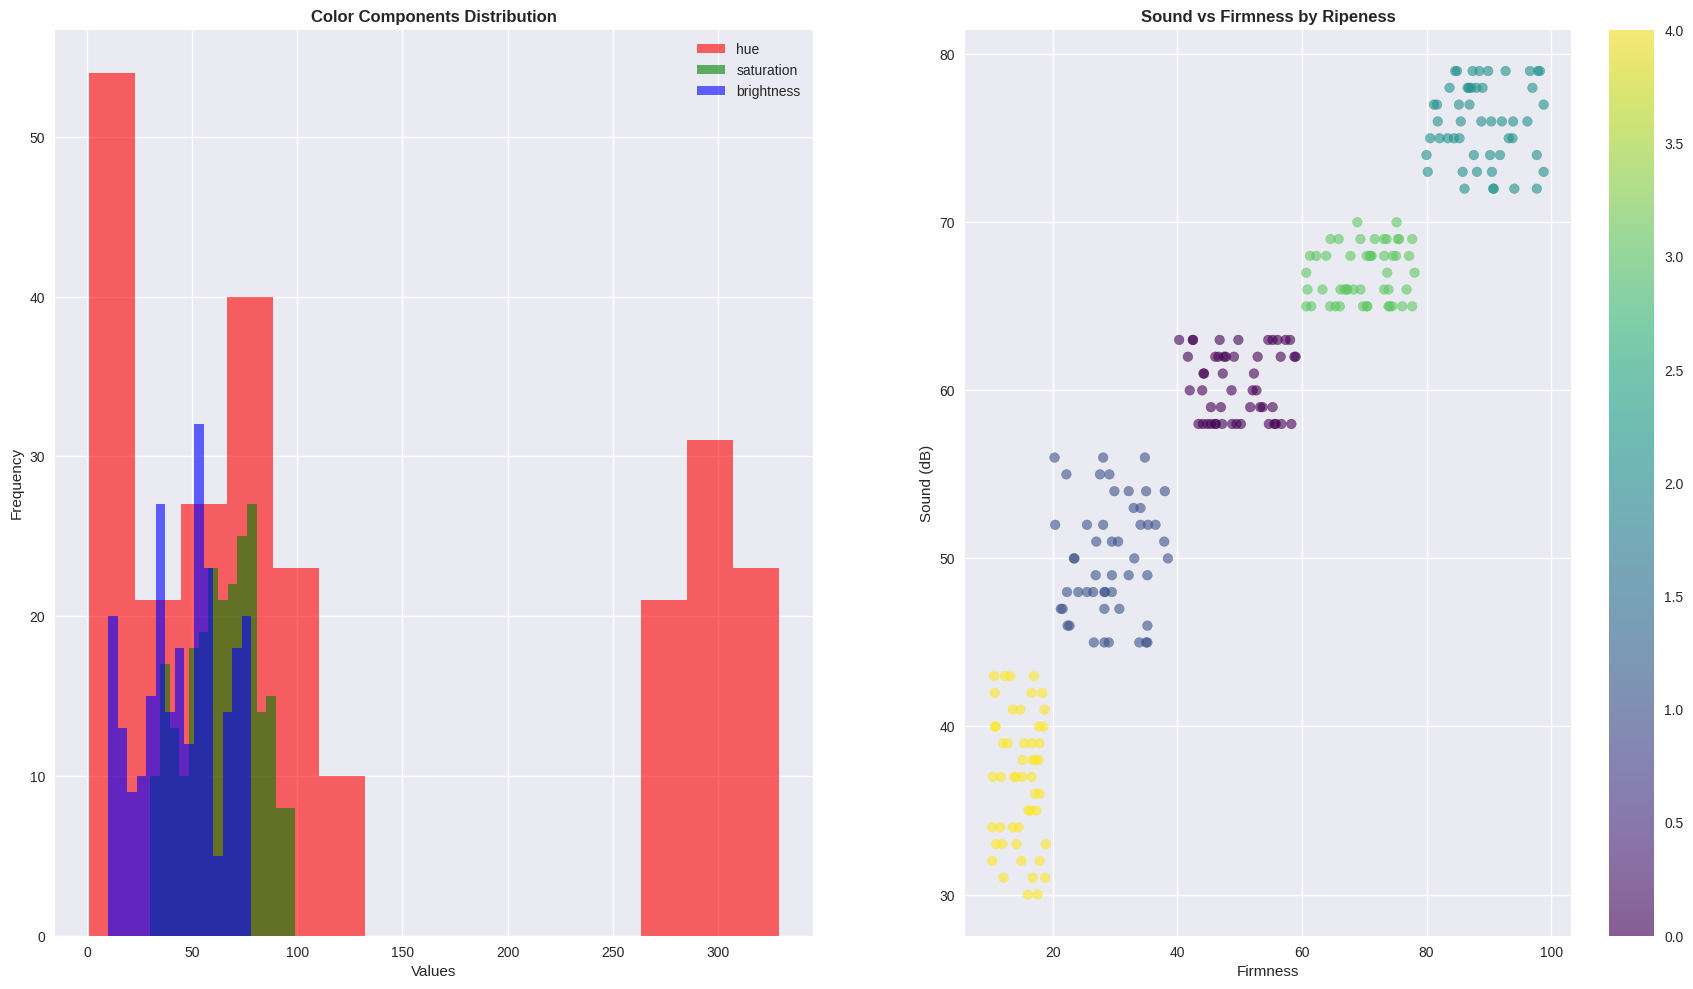

In [54]:
fig = plt.figure(figsize=(45,40))  # Wider and taller
# Subplot 3: Color components
plt.subplot(3, 4, 3)
colors = ['red', 'green', 'blue']
for i, col in enumerate(['hue', 'saturation', 'brightness']):
    plt.hist(df[col], bins=15, alpha=0.6, label=col, color=colors[i])
plt.title('Color Components Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()

# Subplot 4: Sound vs Firmness by Ripeness
plt.subplot(3, 4, 4)
scatter = plt.scatter(df['firmness'], df['sound_db'], c=df['ripeness'].astype('category').cat.codes,
                     cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('Sound vs Firmness by Ripeness', fontsize=12, fontweight='bold')
plt.xlabel('Firmness')
plt.ylabel('Sound (dB)')



([0, 1, 2, 3, 4],
 [Text(0, 0, 'ripe'),
  Text(1, 0, 'pre-conditioned'),
  Text(2, 0, 'hard'),
  Text(3, 0, 'breaking'),
  Text(4, 0, 'firm-ripe')])

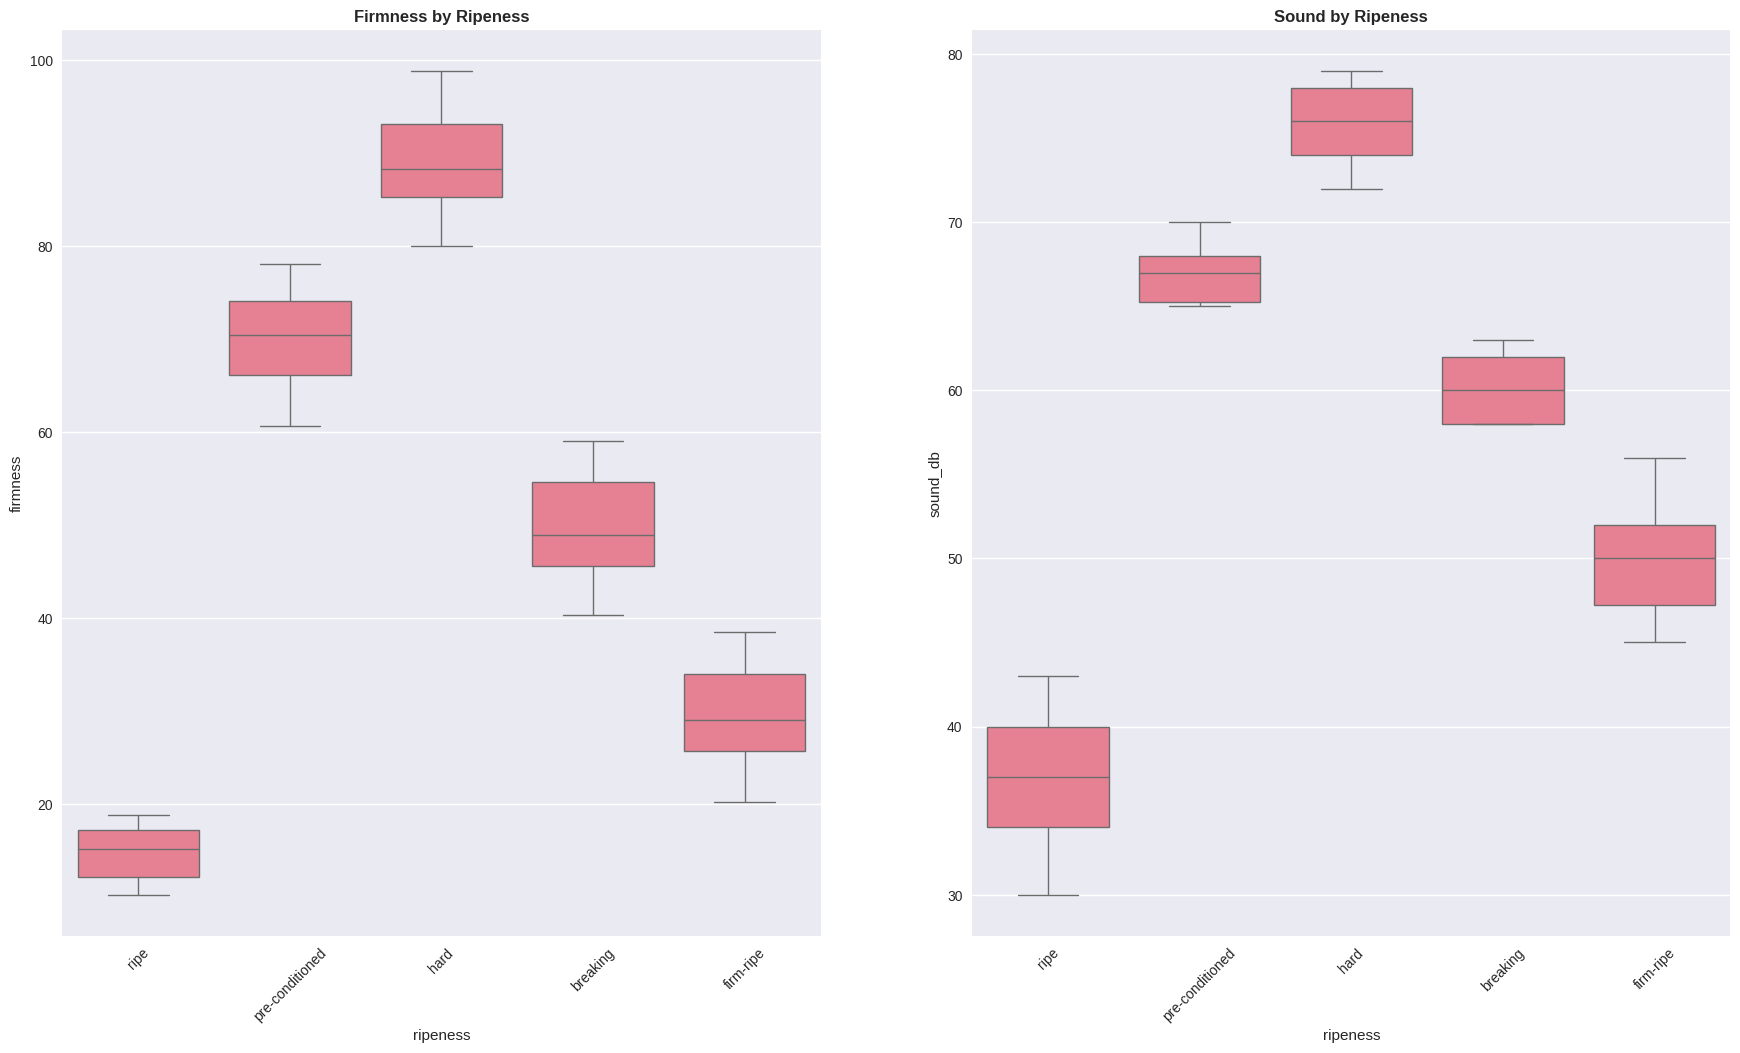

In [55]:
fig = plt.figure(figsize=(45,40))  # Wider and taller
# Subplot 5: Boxplot - Firmness by Ripeness
plt.subplot(3, 4, 5)
sns.boxplot(data=df, x='ripeness', y='firmness')
plt.title('Firmness by Ripeness', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)

# Subplot 6: Boxplot - Sound by Ripeness
plt.subplot(3, 4, 6)
sns.boxplot(data=df, x='ripeness', y='sound_db')
plt.title('Sound by Ripeness', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)



Text(0, 0.5, 'Saturation')

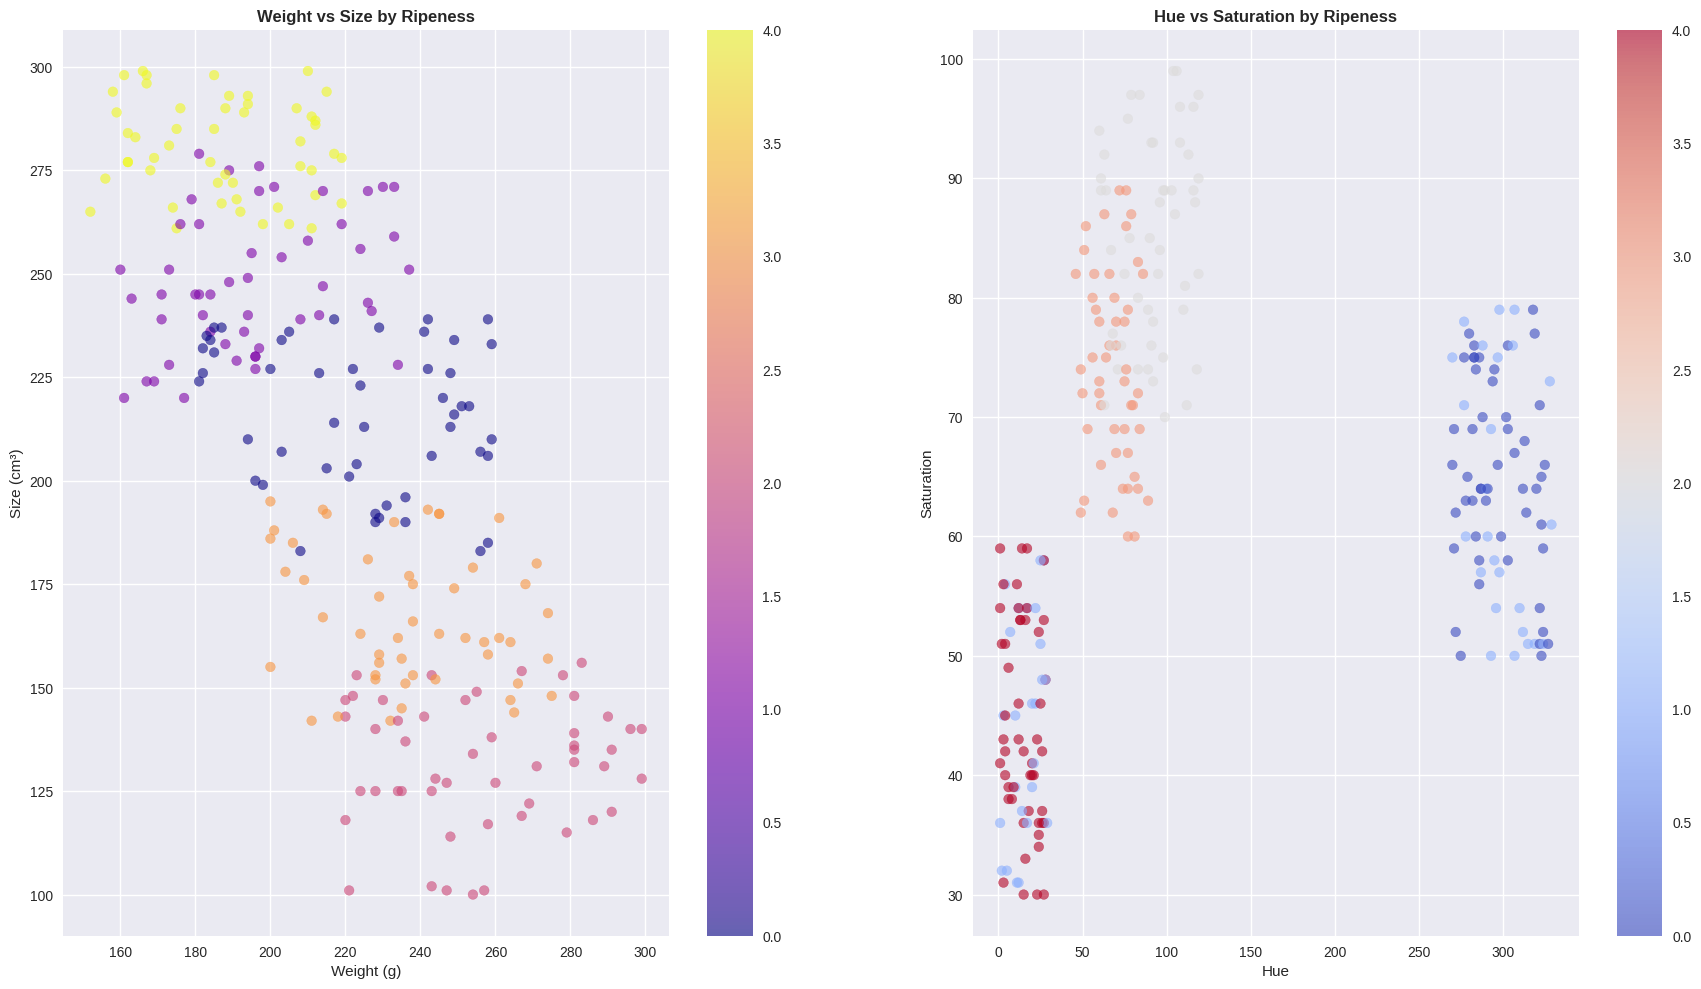

In [56]:
fig = plt.figure(figsize=(45,40))  # Wider and taller
# Subplot 7: Weight vs Size colored by Ripeness
plt.subplot(3, 4, 7)
scatter = plt.scatter(df['weight_g'], df['size_cm3'], c=df['ripeness'].astype('category').cat.codes,
                     cmap='plasma', alpha=0.6)
plt.colorbar(scatter)
plt.title('Weight vs Size by Ripeness', fontsize=12, fontweight='bold')
plt.xlabel('Weight (g)')
plt.ylabel('Size (cm³)')

# Subplot 8: Hue vs Saturation by Ripeness
plt.subplot(3, 4, 8)
scatter = plt.scatter(df['hue'], df['saturation'], c=df['ripeness'].astype('category').cat.codes,
                     cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter)
plt.title('Hue vs Saturation by Ripeness', fontsize=12, fontweight='bold')
plt.xlabel('Hue')
plt.ylabel('Saturation')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'ripe'),
  Text(1, 0, 'firm-ripe'),
  Text(2, 0, 'breaking'),
  Text(3, 0, 'pre-conditioned'),
  Text(4, 0, 'hard')])

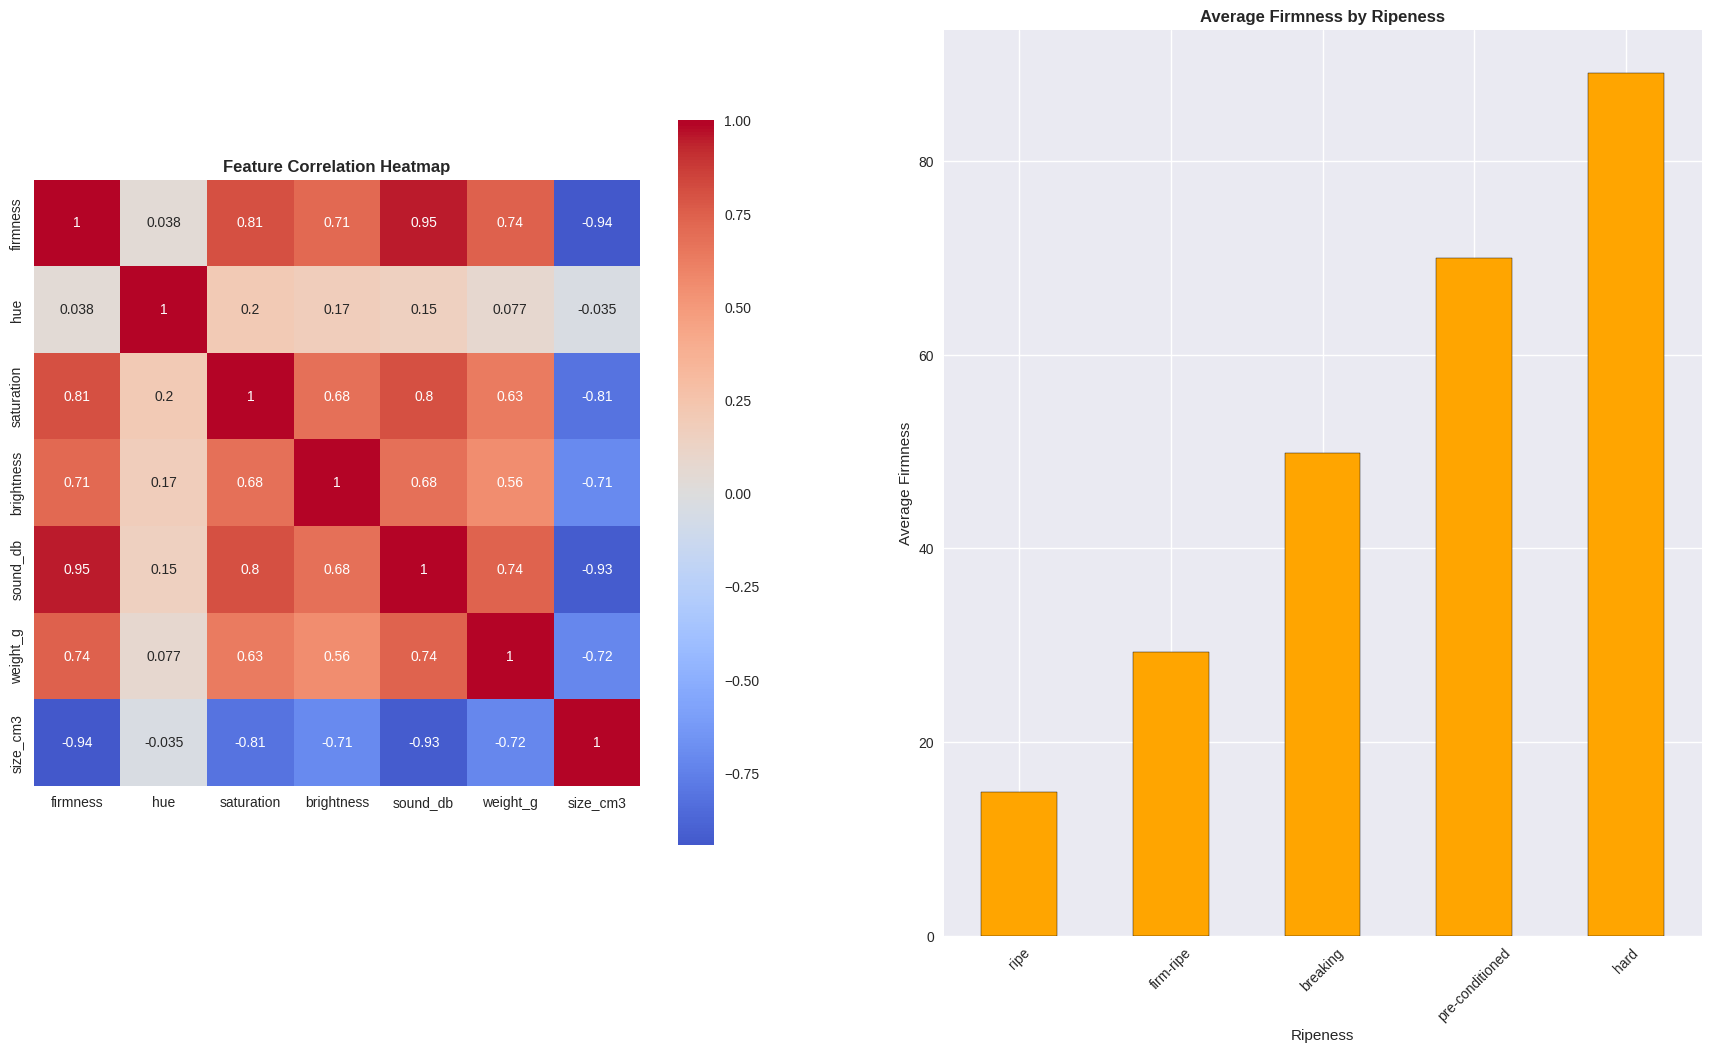

In [57]:
fig = plt.figure(figsize=(45,40))  # Wider and taller
# Subplot 9: Feature correlation heatmap
plt.subplot(3, 4, 9)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap', fontsize=12, fontweight='bold')

# Subplot 10: Average firmness by ripeness
plt.subplot(3, 4, 10)
avg_firmness = df.groupby('ripeness')['firmness'].mean().sort_values()
avg_firmness.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Average Firmness by Ripeness', fontsize=12, fontweight='bold')
plt.xlabel('Ripeness')
plt.ylabel('Average Firmness')
plt.xticks(rotation=45)

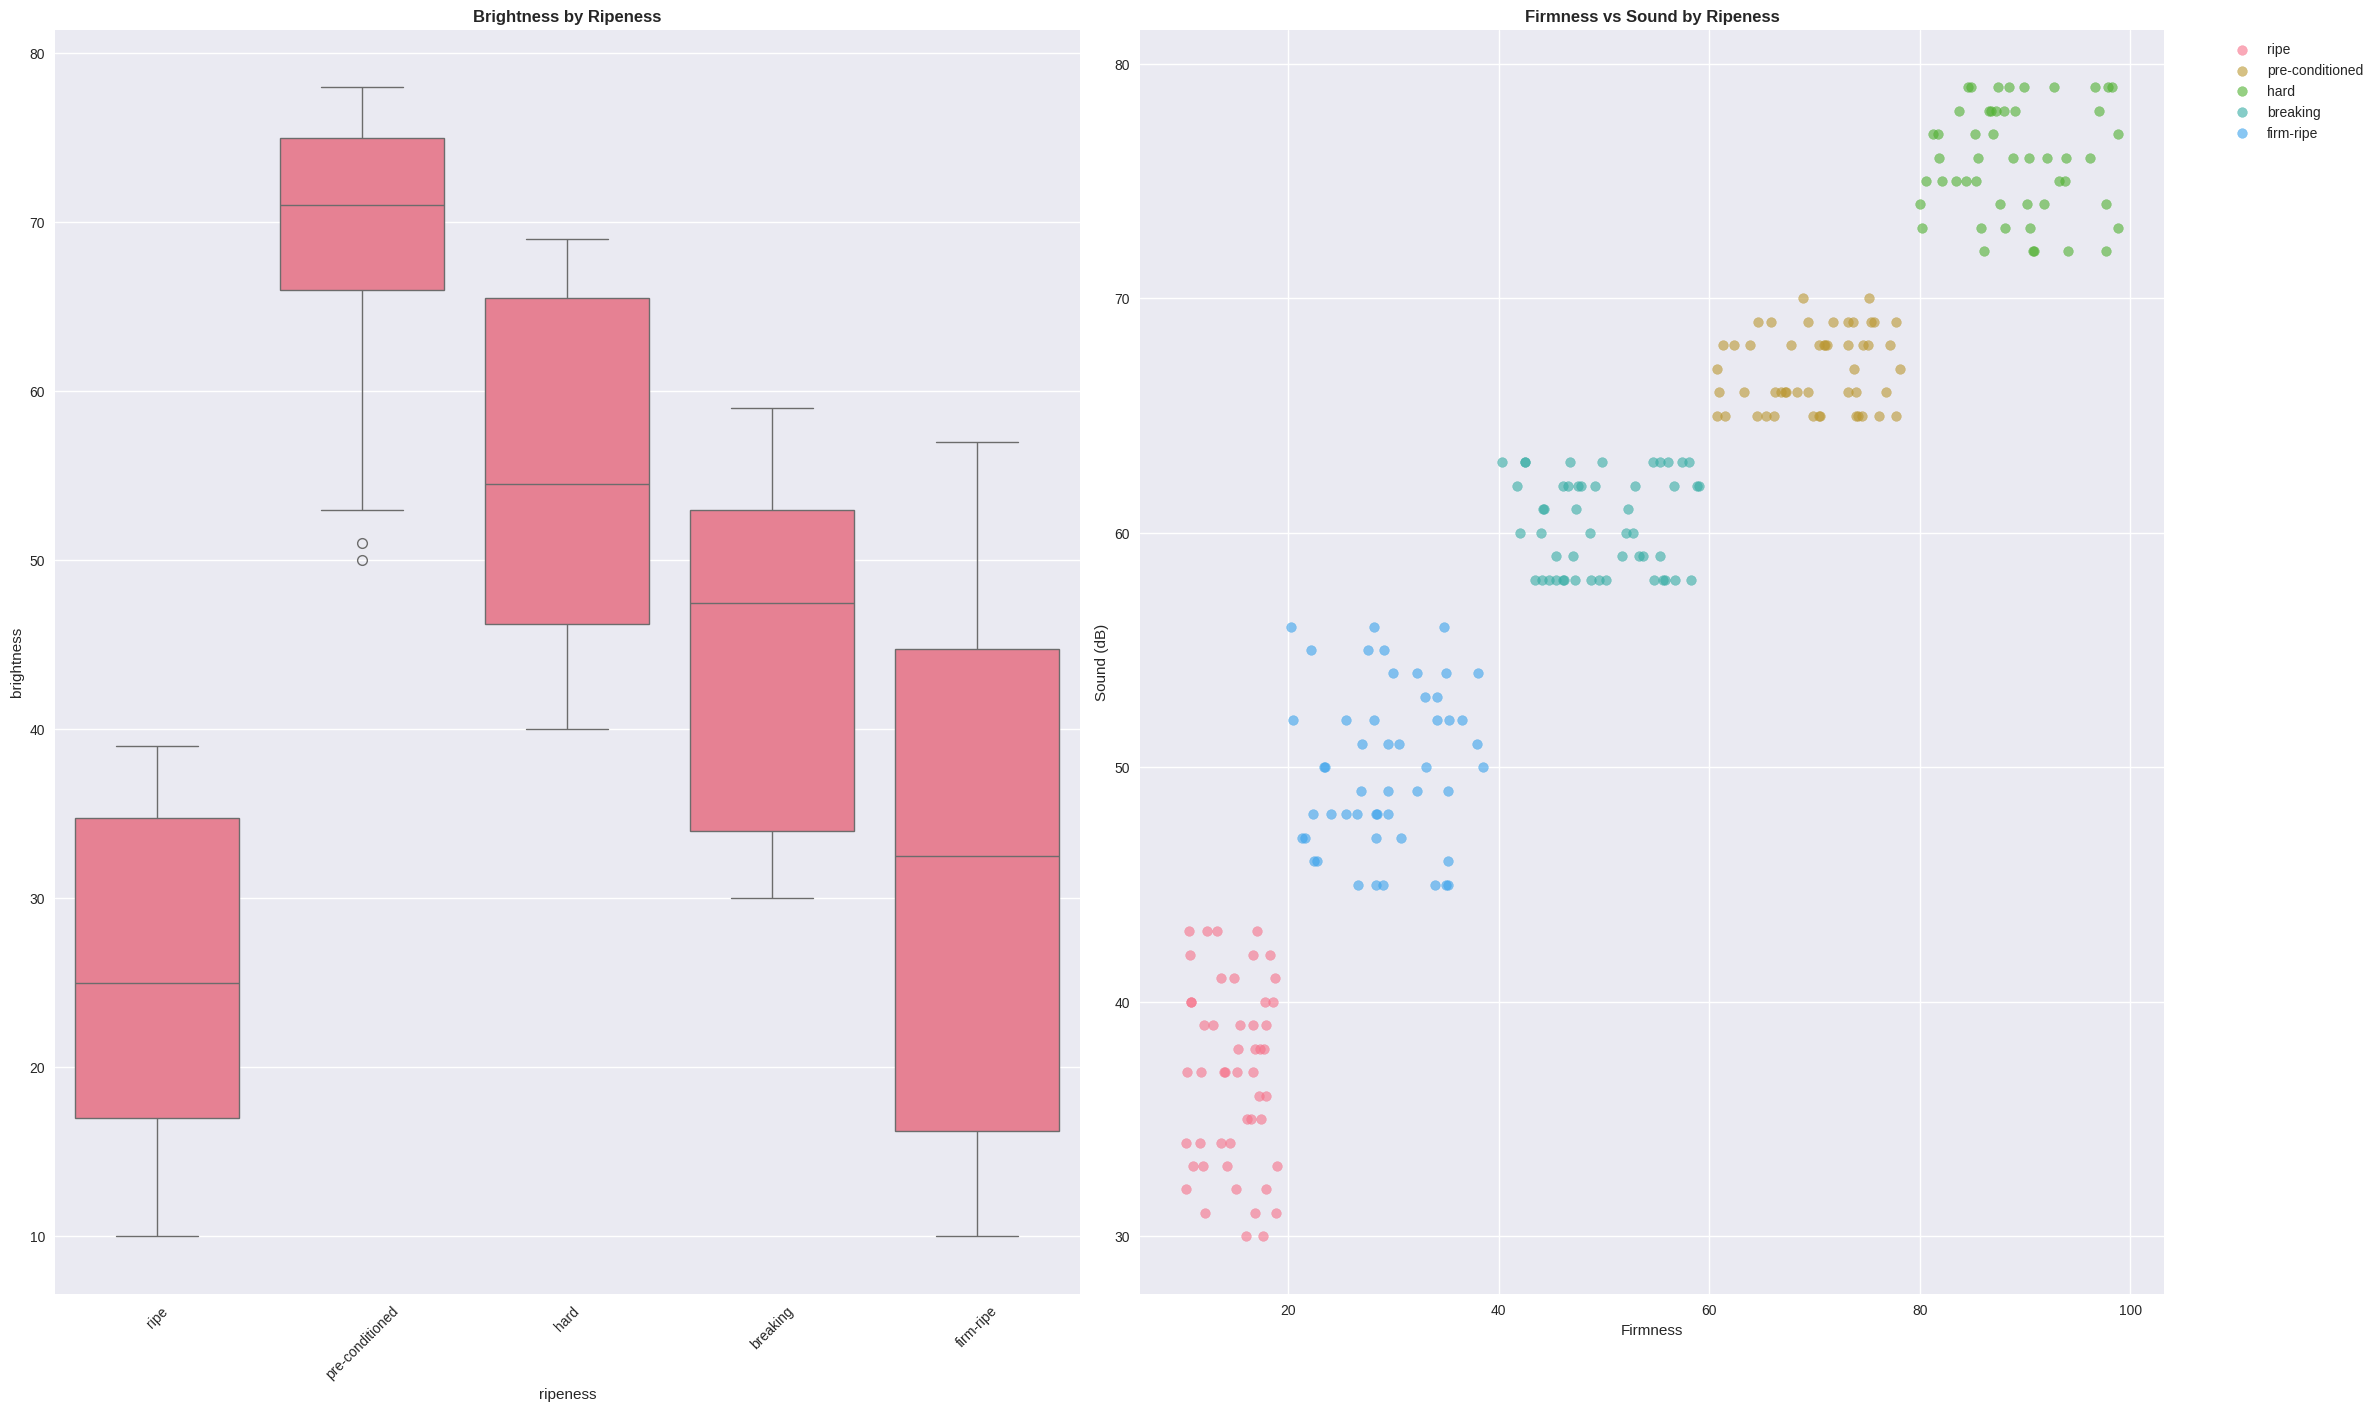

In [58]:
fig = plt.figure(figsize=(45,40))  # Wider and taller
# Subplot 11: Brightness by Ripeness
plt.subplot(3, 4, 11)
sns.boxplot(data=df, x='ripeness', y='brightness')
plt.title('Brightness by Ripeness', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)

# Subplot 12: Pairplot sample (just firmness vs sound)
plt.subplot(3, 4, 12)
for ripeness in df['ripeness'].unique():
    subset = df[df['ripeness'] == ripeness]
    plt.scatter(subset['firmness'], subset['sound_db'], alpha=0.6, label=ripeness)
plt.xlabel('Firmness')
plt.ylabel('Sound (dB)')
plt.title('Firmness vs Sound by Ripeness', fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


#Statistical Analysis

In [59]:
print("\n" + "="*50)
print("📈 STATISTICAL INSIGHTS")
print("="*50)

# Feature importance by variance
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'ripeness' in numeric_features:
    numeric_features.remove('ripeness')

print("Feature variance (normalized):")
for feature in numeric_features:
    variance = np.var(df[feature])
    print(f"{feature}: {variance:.4f}")

# Correlation with target (if numeric encoding is possible)
le_temp = LabelEncoder()
df_temp = df.copy()
df_temp['ripeness_encoded'] = le_temp.fit_transform(df_temp['ripeness'])

print(f"\nCorrelation with ripeness:")
correlations = df_temp[numeric_features + ['ripeness_encoded']].corr()['ripeness_encoded'].sort_values(key=abs, ascending=False)
for feature, corr in correlations.items():
    if feature != 'ripeness_encoded':
        print(f"{feature}: {corr:.4f}")



📈 STATISTICAL INSIGHTS
Feature variance (normalized):
firmness: 741.0954
hue: 13666.3489
saturation: 300.7573
brightness: 363.9708
sound_db: 190.7277
weight_g: 1178.9847
size_cm3: 3116.8293

Correlation with ripeness:
hue: -0.7910
sound_db: -0.3068
saturation: -0.1773
firmness: -0.1517
weight_g: -0.1265
size_cm3: 0.1219
brightness: -0.0197


#ADVANCED DATA PREPROCESSING

In [60]:
print("\n" + "="*60)
print("🔧 DATA PREPROCESSING")
print("="*60)

# Create a copy for preprocessing
df_processed = df.copy()

# Encode categorical variables
label_encoders = {}

# Encode target variable
le_target = LabelEncoder()
df_processed['ripeness_encoded'] = le_target.fit_transform(df_processed['ripeness'])
print(f"Ripeness encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# Encode color_category if it exists
if 'color_category' in df_processed.columns:
    le_color = LabelEncoder()
    df_processed['color_category_encoded'] = le_color.fit_transform(df_processed['color_category'])
    label_encoders['color_category'] = le_color
    print(f"Color category encoding: {dict(zip(le_color.classes_, le_color.transform(le_color.classes_)))}")

# Feature engineering - create new features
print("\n🔨 Feature Engineering:")

# Color intensity
df_processed['color_intensity'] = df_processed['saturation'] * df_processed['brightness']
print("✅ Created color_intensity feature")

# Density (weight/size)
df_processed['density'] = df_processed['weight_g'] / df_processed['size_cm3']
print("✅ Created density feature")

# Firmness-to-sound ratio
df_processed['firmness_sound_ratio'] = df_processed['firmness'] / (df_processed['sound_db'] + 1)  # +1 to avoid division by zero
print("✅ Created firmness_sound_ratio feature")

# Normalize hue to 0-1 range if it's in 0-360 range
if df_processed['hue'].max() > 1:
    df_processed['hue_normalized'] = df_processed['hue'] / 360.0
    print("✅ Created normalized hue feature")


🔧 DATA PREPROCESSING
Ripeness encoding: {'breaking': np.int64(0), 'firm-ripe': np.int64(1), 'hard': np.int64(2), 'pre-conditioned': np.int64(3), 'ripe': np.int64(4)}
Color category encoding: {'black': np.int64(0), 'dark green': np.int64(1), 'green': np.int64(2), 'purple': np.int64(3)}

🔨 Feature Engineering:
✅ Created color_intensity feature
✅ Created density feature
✅ Created firmness_sound_ratio feature
✅ Created normalized hue feature


#Feature modeling

In [61]:
# Select features for modeling
feature_columns = ['firmness', 'hue', 'saturation', 'brightness', 'sound_db', 'weight_g', 'size_cm3',
                  'color_intensity', 'density', 'firmness_sound_ratio']

if 'color_category_encoded' in df_processed.columns:
    feature_columns.append('color_category_encoded')
if 'hue_normalized' in df_processed.columns:
    feature_columns.append('hue_normalized')

# Prepare features and target
X = df_processed[feature_columns]
y = df_processed['ripeness_encoded']

print(f"\nFeatures selected: {feature_columns}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features selected: ['firmness', 'hue', 'saturation', 'brightness', 'sound_db', 'weight_g', 'size_cm3', 'color_intensity', 'density', 'firmness_sound_ratio', 'color_category_encoded', 'hue_normalized']
Feature matrix shape: (250, 12)
Target shape: (250,)


#Splitting the data

In [62]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale the features
scaler = RobustScaler()  # More robust to outliers than StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using RobustScaler")


Training set: (200, 12)
Test set: (50, 12)
✅ Features scaled using RobustScaler


#ADVANCED MODELING WITH MULTIPLE ALGORITHMS

In [63]:
print("\n" + "="*60)
print("🤖 MACHINE LEARNING MODELING")
print("="*60)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Store results
results = {}
trained_models = {}
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training and evaluating models...")
print("-" * 50)

for name, model in models.items():
    print(f"\n🔥 Training {name}...")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

    # Train on full training set
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    trained_models[name] = model

    print(f"✅ {name} completed!")
    print(f"   Test Accuracy: {accuracy:.4f}")
    print(f"   CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



🤖 MACHINE LEARNING MODELING
Training and evaluating models...
--------------------------------------------------

🔥 Training Logistic Regression...
✅ Logistic Regression completed!
   Test Accuracy: 0.9600
   CV Score: 0.9700 ± 0.0367

🔥 Training Random Forest...
✅ Random Forest completed!
   Test Accuracy: 1.0000
   CV Score: 0.9950 ± 0.0100

🔥 Training Gradient Boosting...
✅ Gradient Boosting completed!
   Test Accuracy: 1.0000
   CV Score: 1.0000 ± 0.0000

🔥 Training SVM...
✅ SVM completed!
   Test Accuracy: 1.0000
   CV Score: 0.9900 ± 0.0122

🔥 Training KNN...
✅ KNN completed!
   Test Accuracy: 0.9800
   CV Score: 0.9900 ± 0.0122

🔥 Training Decision Tree...
✅ Decision Tree completed!
   Test Accuracy: 1.0000
   CV Score: 1.0000 ± 0.0000


#MODEL EVALUATION AND COMPARISON

In [64]:
print("\n" + "="*60)
print("📊 MODEL EVALUATION & COMPARISON")
print("="*60)

# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1_score', 'cv_mean', 'cv_std']]
results_df = results_df.sort_values('accuracy', ascending=False)

print("Model Performance Comparison:")
print("=" * 80)
print(results_df.round(4))


📊 MODEL EVALUATION & COMPARISON
Model Performance Comparison:
                    accuracy precision recall f1_score cv_mean    cv_std
Random Forest            1.0       1.0    1.0      1.0   0.995      0.01
Gradient Boosting        1.0       1.0    1.0      1.0     1.0       0.0
SVM                      1.0       1.0    1.0      1.0    0.99  0.012247
Decision Tree            1.0       1.0    1.0      1.0     1.0       0.0
KNN                     0.98  0.981818   0.98  0.97995    0.99  0.012247
Logistic Regression     0.96  0.963636   0.96  0.95873    0.97  0.036742


#The Best Model

In [65]:
# Find best model
best_model_name = results_df.index[0]
best_model = trained_models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")

# Detailed evaluation of best model
print(f"\n📋 Detailed Classification Report for {best_model_name}:")
print("-" * 60)
y_pred_best = results[best_model_name]['predictions']
print(classification_report(y_test, y_pred_best, target_names=le_target.classes_))



🏆 Best Model: Random Forest
   Accuracy: 1.0000

📋 Detailed Classification Report for Random Forest:
------------------------------------------------------------
                 precision    recall  f1-score   support

       breaking       1.00      1.00      1.00        10
      firm-ripe       1.00      1.00      1.00        10
           hard       1.00      1.00      1.00        10
pre-conditioned       1.00      1.00      1.00        10
           ripe       1.00      1.00      1.00        10

       accuracy                           1.00        50
      macro avg       1.00      1.00      1.00        50
   weighted avg       1.00      1.00      1.00        50



#PLOTS

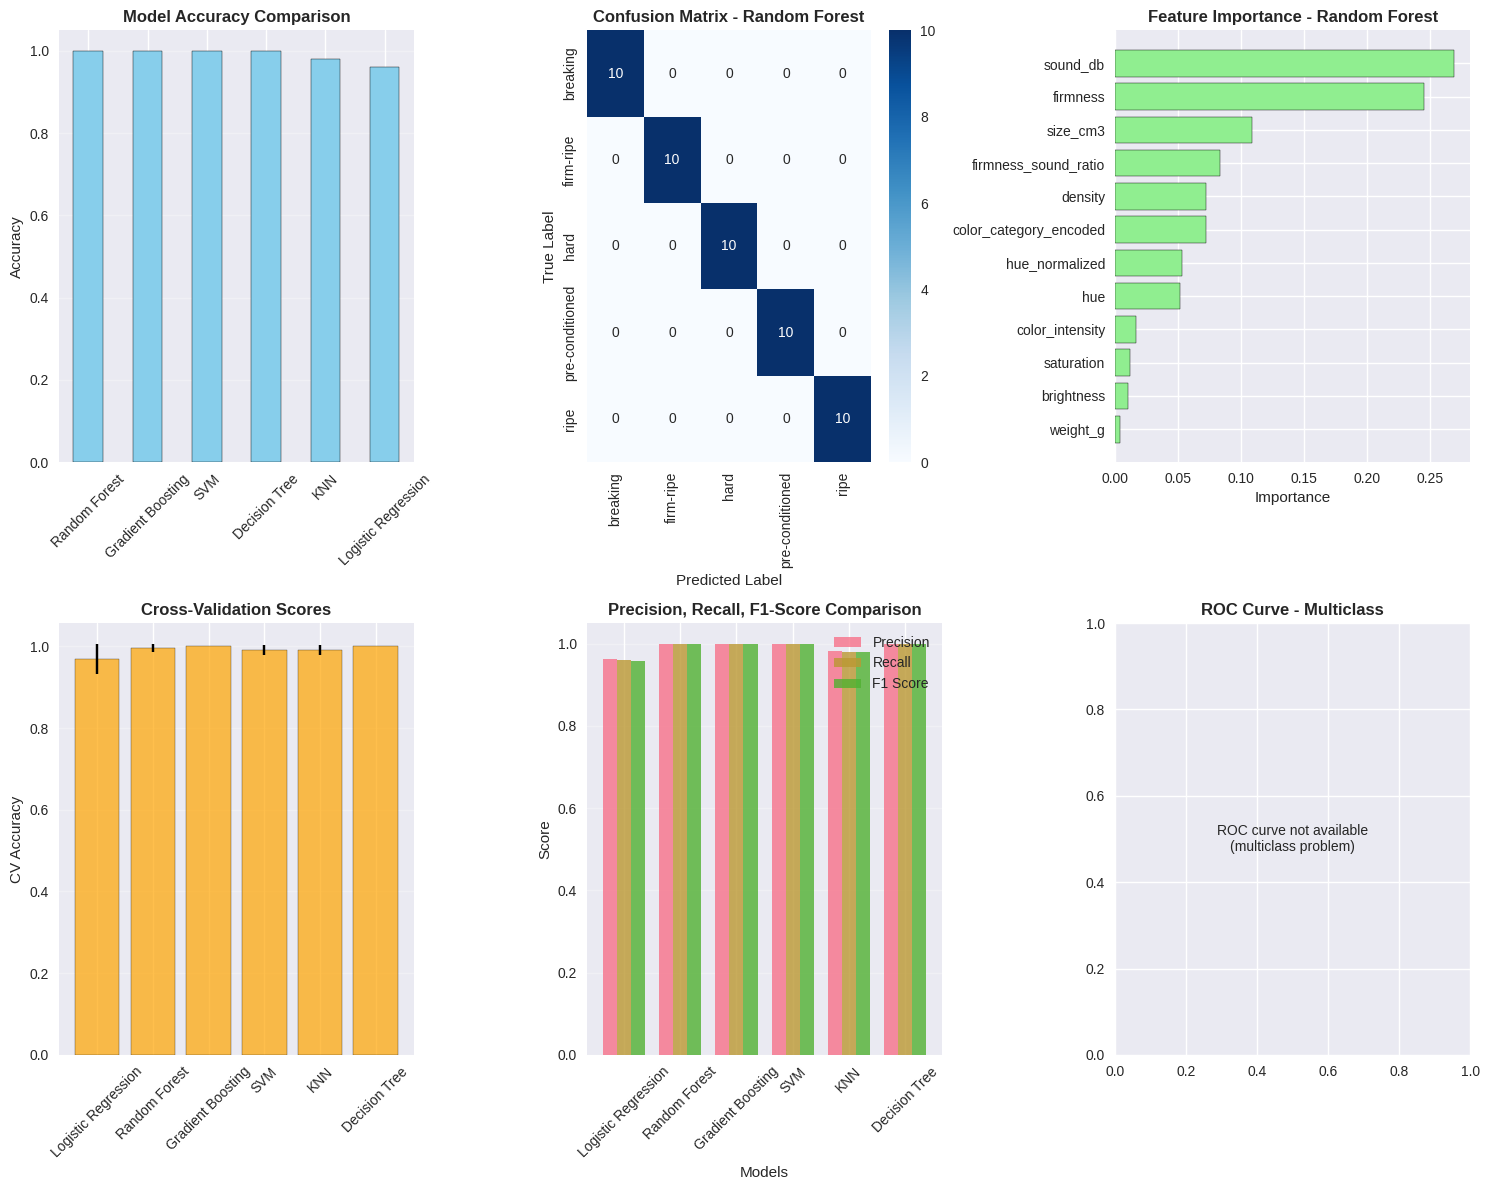

In [66]:
# Confusion Matrix
plt.figure(figsize=(15, 12))

# Plot 1: Model Comparison
plt.subplot(2, 3, 1)
results_df['accuracy'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Model Accuracy Comparison', fontweight='bold')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Plot 2: Confusion Matrix
plt.subplot(2, 3, 2)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 3: Feature Importance (for tree-based models)
plt.subplot(2, 3, 3)
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)

    plt.barh(importance_df['feature'], importance_df['importance'], color='lightgreen', edgecolor='black')
    plt.title(f'Feature Importance - {best_model_name}', fontweight='bold')
    plt.xlabel('Importance')
else:
    plt.text(0.5, 0.5, 'Feature importance not available\nfor this model type',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance - Not Available', fontweight='bold')

# Plot 4: CV Scores
plt.subplot(2, 3, 4)
cv_means = [results[model]['cv_mean'] for model in results.keys()]
cv_stds = [results[model]['cv_std'] for model in results.keys()]
x_pos = range(len(results))
plt.bar(x_pos, cv_means, yerr=cv_stds, capsize=5, color='orange', alpha=0.7, edgecolor='black')
plt.xticks(x_pos, results.keys(), rotation=45)
plt.title('Cross-Validation Scores', fontweight='bold')
plt.ylabel('CV Accuracy')
plt.grid(axis='y', alpha=0.3)

# Plot 5: Precision-Recall-F1 Comparison
plt.subplot(2, 3, 5)
metrics = ['precision', 'recall', 'f1_score']
x = np.arange(len(results))
width = 0.25

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in results.keys()]
    plt.bar(x + i*width, values, width, label=metric.replace('_', ' ').title(), alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Precision, Recall, F1-Score Comparison', fontweight='bold')
plt.xticks(x + width, results.keys(), rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Plot 6: ROC Curve (if possible)
plt.subplot(2, 3, 6)
if len(le_target.classes_) == 2:  # Binary classification
    from sklearn.metrics import roc_curve, auc
    y_proba = results[best_model_name]['probabilities']
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve', fontweight='bold')
        plt.legend(loc="lower right")
    else:
        plt.text(0.5, 0.5, 'ROC curve not available\n(no probabilities)',
                ha='center', va='center', transform=plt.gca().transAxes)
else:
    plt.text(0.5, 0.5, 'ROC curve not available\n(multiclass problem)',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('ROC Curve - Multiclass', fontweight='bold')

plt.tight_layout()
plt.show()


#HYPERPARAMETER TUNING FOR BEST MODEL

In [67]:
print("\n" + "="*60)
print("⚙️ HYPERPARAMETER TUNING")
print("="*60)

# Hyperparameter tuning for the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'poly']
    }
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
else:
    param_grid = {}

if param_grid:
    print(f"Tuning hyperparameters for {best_model_name}...")

    # Create a new instance of the best model
    base_model = type(best_model)(**{k: v for k, v in best_model.get_params().items() if k in ['random_state']})

    # Grid search
    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)

    # Best model
    best_tuned_model = grid_search.best_estimator_

    print(f"✅ Best parameters: {grid_search.best_params_}")
    print(f"✅ Best CV score: {grid_search.best_score_:.4f}")

    # Evaluate tuned model
    y_pred_tuned = best_tuned_model.predict(X_test_scaled)
    tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

    print(f"✅ Tuned model test accuracy: {tuned_accuracy:.4f}")
    print(f"✅ Improvement: {tuned_accuracy - results[best_model_name]['accuracy']:.4f}")

    # Update best model if tuned version is better
    if tuned_accuracy > results[best_model_name]['accuracy']:
        best_model = best_tuned_model
        print("🎉 Tuned model is better! Using tuned version.")
    else:
        print("📝 Original model performs better. Keeping original.")
else:
    print(f"Hyperparameter tuning not implemented for {best_model_name}")



⚙️ HYPERPARAMETER TUNING
Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
✅ Best CV score: 1.0000
✅ Tuned model test accuracy: 1.0000
✅ Improvement: 0.0000
📝 Original model performs better. Keeping original.


#ADVANCED FEATURE ANALYSIS


🔍 ADVANCED FEATURE ANALYSIS
Calculating permutation importance...

Permutation Feature Importance:
                   feature  importance_mean  importance_std
0                 firmness            0.034        0.025377
4                 sound_db            0.020        0.008944
2               saturation            0.000        0.000000
1                      hue            0.000        0.000000
3               brightness            0.000        0.000000
5                 weight_g            0.000        0.000000
6                 size_cm3            0.000        0.000000
7          color_intensity            0.000        0.000000
8                  density            0.000        0.000000
9     firmness_sound_ratio            0.000        0.000000
10  color_category_encoded            0.000        0.000000
11          hue_normalized            0.000        0.000000


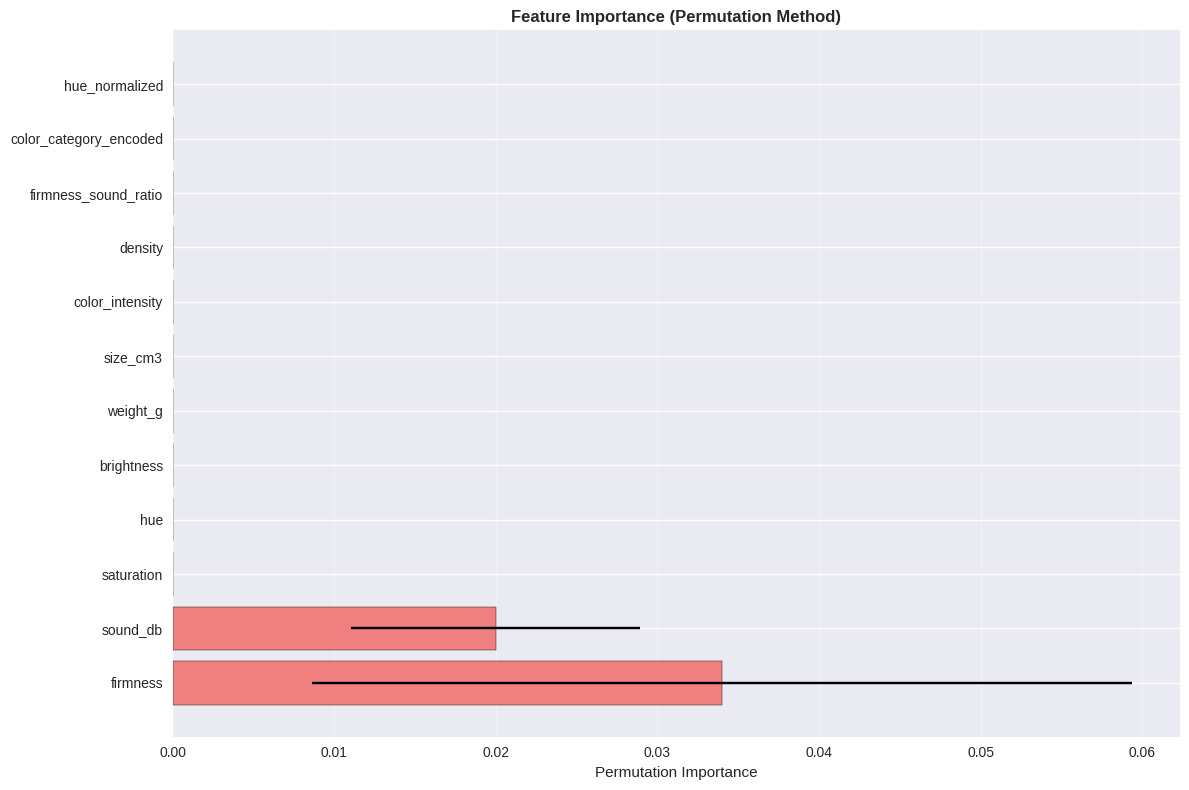

In [68]:
print("\n" + "="*60)
print("🔍 ADVANCED FEATURE ANALYSIS")
print("="*60)

# Permutation importance for better feature understanding
print("Calculating permutation importance...")
perm_importance = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nPermutation Feature Importance:")
print(feature_importance_df)

# Visualize permutation importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance_mean'],
         xerr=feature_importance_df['importance_std'], capsize=5, color='lightcoral', edgecolor='black')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation Method)', fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

#DIMENSIONALITY REDUCTION VISUALIZATION


📐 DIMENSIONALITY REDUCTION VISUALIZATION
Performing PCA...
Performing t-SNE...


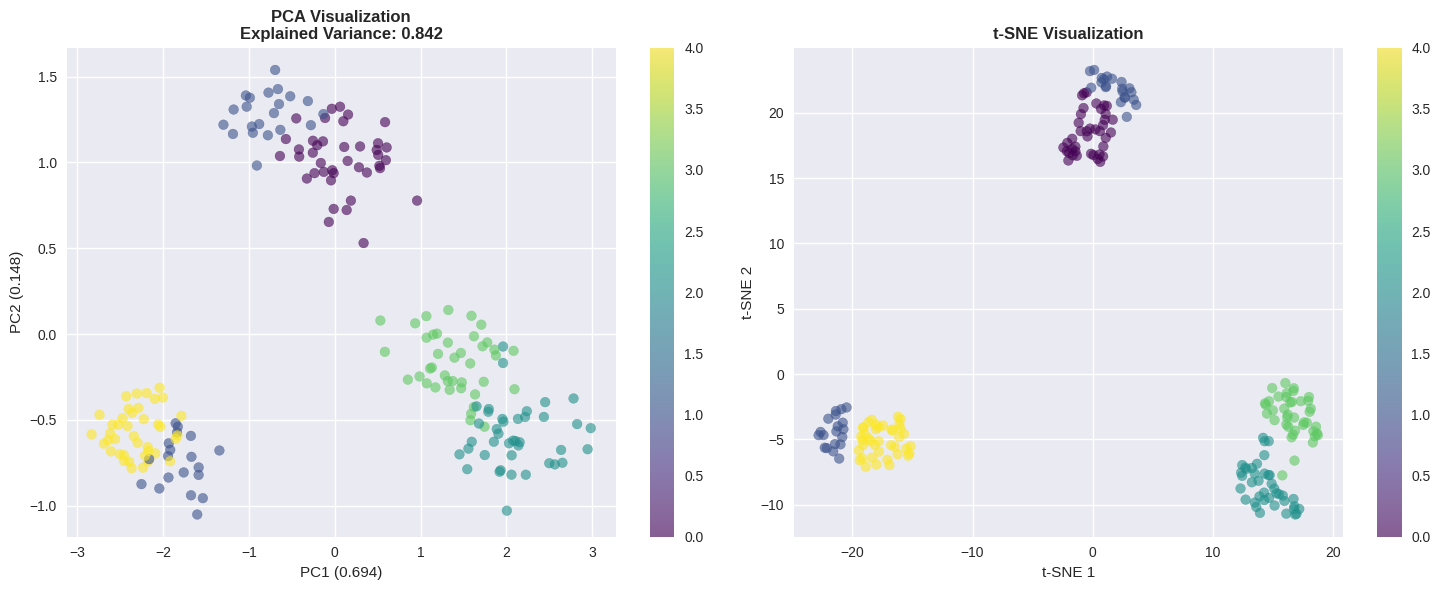

In [69]:
print("\n" + "="*60)
print("📐 DIMENSIONALITY REDUCTION VISUALIZATION")
print("="*60)

# PCA
print("Performing PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# t-SNE
print("Performing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_train_scaled)

# Visualization
plt.figure(figsize=(15, 6))

# PCA plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title(f'PCA Visualization\nExplained Variance: {pca.explained_variance_ratio_.sum():.3f}', fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')

# t-SNE plot
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualization', fontweight='bold')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

#MODEL PERSISTENCE AND DEPLOYMENT PREPARATION

In [70]:
print("\n" + "="*60)
print("💾 MODEL PERSISTENCE")
print("="*60)

# Save the best model and preprocessing objects
model_artifacts = {
    'model': best_model,
    'scaler': scaler,
    'label_encoder': le_target,
    'feature_columns': feature_columns,
    'model_name': best_model_name
}

# Save artifacts
print("Saving model artifacts...")
joblib.dump(model_artifacts, 'avocado_ripeness_model.pkl')
print("✅ Model saved as 'avocado_ripeness_model.pkl'")

print(f"✅ Model artifacts saved:")
print(f"   - Best model: {best_model_name}")
print(f"   - Features: {len(feature_columns)}")
print(f"   - Scaler: {type(scaler).__name__}")
print(f"   - Accuracy: {results[best_model_name]['accuracy']:.4f}")


💾 MODEL PERSISTENCE
Saving model artifacts...
✅ Model saved as 'avocado_ripeness_model.pkl'
✅ Model artifacts saved:
   - Best model: Random Forest
   - Features: 12
   - Scaler: RobustScaler
   - Accuracy: 1.0000


# PREDICTION FUNCTION

In [71]:
print("\n" + "="*60)
print("🎯 PREDICTION FUNCTION")
print("="*60)

def predict_avocado_ripeness(firmness, hue, saturation, brightness, sound_db, weight_g, size_cm3, color_category=None):
    """
    Predict avocado ripeness based on physical and visual features.

    Parameters:
    - firmness: float, firmness measurement
    - hue: int, color hue value
    - saturation: int, color saturation
    - brightness: int, color brightness
    - sound_db: int, sound when tapped
    - weight_g: int, weight in grams
    - size_cm3: int, size in cubic centimeters
    - color_category: str, optional color category

    Returns:
    - prediction: str, predicted ripeness level
    - confidence: float, prediction confidence
    """

    # Create feature array
    features = [firmness, hue, saturation, brightness, sound_db, weight_g, size_cm3]

    # Add engineered features
    color_intensity = saturation * brightness
    density = weight_g / size_cm3
    firmness_sound_ratio = firmness / (sound_db + 1)

    features.extend([color_intensity, density, firmness_sound_ratio])

    # Add color category if available
    if 'color_category_encoded' in feature_columns and color_category:
        if 'color_category' in label_encoders:
            try:
                color_encoded = label_encoders['color_category'].transform([color_category])[0]
                features.append(color_encoded)
            except ValueError:
                features.append(0)  # Default encoding

    # Add normalized hue if available
    if 'hue_normalized' in feature_columns:
        hue_normalized = hue / 360.0 if hue > 1 else hue
        features.append(hue_normalized)

    # Ensure correct number of features
    while len(features) < len(feature_columns):
        features.append(0)

    features = features[:len(feature_columns)]  # Trim if too many

    # Scale features
    features_scaled = scaler.transform([features])

    # Make prediction
    prediction_encoded = best_model.predict(features_scaled)[0]
    prediction = le_target.inverse_transform([prediction_encoded])[0]

    # Get confidence (probability)
    if hasattr(best_model, 'predict_proba'):
        probabilities = best_model.predict_proba(features_scaled)[0]
        confidence = max(probabilities)
    else:
        confidence = 1.0  # Default confidence for models without probability

    return prediction, confidence

# Example prediction
print("🧪 Example Prediction:")
sample_prediction, sample_confidence = predict_avocado_ripeness(
    firmness=5.2, hue=120, saturation=80, brightness=60,
    sound_db=45, weight_g=180, size_cm3=150
)
print(f"Sample Avocado Prediction: {sample_prediction}")
print(f"Confidence: {sample_confidence:.3f}")


🎯 PREDICTION FUNCTION
🧪 Example Prediction:
Sample Avocado Prediction: firm-ripe
Confidence: 0.390


# BUSINESS INSIGHTS AND RECOMMENDATIONS

In [72]:
print("\n" + "="*60)
print("💼 BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*60)

# Key insights
print("📊 Key Findings:")
print("-" * 40)

# Feature importance insights
top_features = feature_importance_df.head(3)
print(f"🔥 Top 3 Most Important Features:")
for idx, row in top_features.iterrows():
    print(f"   {idx+1}. {row['feature']}: {row['importance_mean']:.4f}")

# Model performance insights
print(f"\n🎯 Model Performance:")
print(f"   • Best Model: {best_model_name}")
print(f"   • Accuracy: {results[best_model_name]['accuracy']:.3f}")
print(f"   • Cross-validation: {results[best_model_name]['cv_mean']:.3f} ± {results[best_model_name]['cv_std']:.3f}")

# Class distribution insights
print(f"\n📈 Dataset Insights:")
print(f"   • Total samples: {len(df)}")
print(f"   • Number of ripeness classes: {len(df['ripeness'].unique())}")
print(f"   • Most common ripeness: {df['ripeness'].mode()[0]}")
print(f"   • Class imbalance ratio: {ripeness_counts.max() / ripeness_counts.min():.2f}")

# Correlation insights
high_corr_features = correlations[abs(correlations) > 0.3].drop('ripeness_encoded')
if len(high_corr_features) > 0:
    print(f"\n🔗 Features Highly Correlated with Ripeness (|r| > 0.3):")
    for feature, corr in high_corr_features.items():
        print(f"   • {feature}: {corr:.3f}")

print(f"\n💡 Business Recommendations:")
print("-" * 40)
print("1. 🏪 Retail Applications:")
print("   • Implement automated sorting systems using top features")
print("   • Train staff to focus on most predictive characteristics")
print("   • Reduce food waste through better ripeness prediction")

print("\n2. 🚚 Supply Chain Optimization:")
print("   • Predict optimal harvest timing")
print("   • Improve inventory management")
print("   • Reduce spoilage during transportation")

print("\n3. 📱 Consumer Applications:")
print("   • Develop smartphone app for consumers")
print("   • Integrate with smart kitchen devices")
print("   • Provide ripeness recommendations")

print("\n4. 🔬 Quality Control:")
print("   • Standardize quality assessment processes")
print("   • Implement consistent grading systems")
print("   • Monitor product quality over time")



💼 BUSINESS INSIGHTS & RECOMMENDATIONS
📊 Key Findings:
----------------------------------------
🔥 Top 3 Most Important Features:
   1. firmness: 0.0340
   5. sound_db: 0.0200
   3. saturation: 0.0000

🎯 Model Performance:
   • Best Model: Random Forest
   • Accuracy: 1.000
   • Cross-validation: 0.995 ± 0.010

📈 Dataset Insights:
   • Total samples: 250
   • Number of ripeness classes: 5
   • Most common ripeness: breaking
   • Class imbalance ratio: 1.00

🔗 Features Highly Correlated with Ripeness (|r| > 0.3):
   • hue: -0.791
   • sound_db: -0.307

💡 Business Recommendations:
----------------------------------------
1. 🏪 Retail Applications:
   • Implement automated sorting systems using top features
   • Train staff to focus on most predictive characteristics
   • Reduce food waste through better ripeness prediction

2. 🚚 Supply Chain Optimization:
   • Predict optimal harvest timing
   • Improve inventory management
   • Reduce spoilage during transportation

3. 📱 Consumer Applicat

#ADVANCED MODEL ENSEMBLE

In [73]:
print("\n" + "="*60)
print("🎪 ENSEMBLE MODEL CREATION")
print("="*60)

# Create ensemble of top 3 models
top_3_models = results_df.head(3)
print(f"Creating ensemble from top 3 models:")
for i, (model_name, _) in enumerate(top_3_models.iterrows(), 1):
    print(f"{i}. {model_name} (Accuracy: {results[model_name]['accuracy']:.4f})")

# Voting classifier
ensemble_models = [(name, trained_models[name]) for name in top_3_models.index]
ensemble = VotingClassifier(estimators=ensemble_models, voting='soft')

print("\nTraining ensemble model...")
ensemble.fit(X_train_scaled, y_train)

# Evaluate ensemble
y_pred_ensemble = ensemble.predict(X_test_scaled)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_cv_scores = cross_val_score(ensemble, X_train_scaled, y_train, cv=cv, scoring='accuracy')

print(f"✅ Ensemble Model Results:")
print(f"   Test Accuracy: {ensemble_accuracy:.4f}")
print(f"   CV Score: {ensemble_cv_scores.mean():.4f} ± {ensemble_cv_scores.std():.4f}")

# Compare with best individual model
improvement = ensemble_accuracy - results[best_model_name]['accuracy']
print(f"   Improvement over best individual model: {improvement:.4f}")

if ensemble_accuracy > results[best_model_name]['accuracy']:
    print("🎉 Ensemble model performs better!")
    final_model = ensemble
    final_model_name = "Ensemble"
    final_accuracy = ensemble_accuracy
else:
    print("📝 Individual model performs better. Keeping original.")
    final_model = best_model
    final_model_name = best_model_name
    final_accuracy = results[best_model_name]['accuracy']



🎪 ENSEMBLE MODEL CREATION
Creating ensemble from top 3 models:
1. Random Forest (Accuracy: 1.0000)
2. Gradient Boosting (Accuracy: 1.0000)
3. SVM (Accuracy: 1.0000)

Training ensemble model...
✅ Ensemble Model Results:
   Test Accuracy: 1.0000
   CV Score: 1.0000 ± 0.0000
   Improvement over best individual model: 0.0000
📝 Individual model performs better. Keeping original.


#FINAL EVALUATION AND SUMMARY

In [74]:
print("\n" + "="*60)
print("📋 FINAL PROJECT SUMMARY")
print("="*60)

# Final model evaluation
y_pred_final = final_model.predict(X_test_scaled)
final_report = classification_report(y_test, y_pred_final, target_names=le_target.classes_, output_dict=True)

print(f"🏆 FINAL MODEL: {final_model_name}")
print(f"   Accuracy: {final_accuracy:.4f}")
print(f"   Macro Avg F1-Score: {final_report['macro avg']['f1-score']:.4f}")
print(f"   Weighted Avg F1-Score: {final_report['weighted avg']['f1-score']:.4f}")

print(f"\n📊 Per-Class Performance:")
for class_name in le_target.classes_:
    metrics = final_report[class_name]
    print(f"   {class_name}:")
    print(f"      Precision: {metrics['precision']:.3f}")
    print(f"      Recall: {metrics['recall']:.3f}")
    print(f"      F1-Score: {metrics['f1-score']:.3f}")

# Save final model
final_artifacts = {
    'model': final_model,
    'scaler': scaler,
    'label_encoder': le_target,
    'feature_columns': feature_columns,
    'model_name': final_model_name,
    'accuracy': final_accuracy,
    'feature_importance': feature_importance_df.to_dict() if not feature_importance_df.empty else None
}

joblib.dump(final_artifacts, 'avocado_ripeness_final_model.pkl')
print(f"\n💾 Final model saved as 'avocado_ripeness_final_model.pkl'")



📋 FINAL PROJECT SUMMARY
🏆 FINAL MODEL: Random Forest
   Accuracy: 1.0000
   Macro Avg F1-Score: 1.0000
   Weighted Avg F1-Score: 1.0000

📊 Per-Class Performance:
   breaking:
      Precision: 1.000
      Recall: 1.000
      F1-Score: 1.000
   firm-ripe:
      Precision: 1.000
      Recall: 1.000
      F1-Score: 1.000
   hard:
      Precision: 1.000
      Recall: 1.000
      F1-Score: 1.000
   pre-conditioned:
      Precision: 1.000
      Recall: 1.000
      F1-Score: 1.000
   ripe:
      Precision: 1.000
      Recall: 1.000
      F1-Score: 1.000

💾 Final model saved as 'avocado_ripeness_final_model.pkl'


#INTERACTIVE PREDICTION INTERFACE

In [75]:

print("\n" + "="*60)
print("🎮 INTERACTIVE PREDICTION INTERFACE")
print("="*60)

def interactive_prediction():
    """
    Interactive function to get user input and make predictions
    """
    print("\n🥑 Avocado Ripeness Predictor")
    print("Enter the following measurements:")

    try:
        firmness = float(input("Firmness (0-10): "))
        hue = int(input("Hue (0-360): "))
        saturation = int(input("Saturation (0-100): "))
        brightness = int(input("Brightness (0-100): "))
        sound_db = int(input("Sound when tapped (dB): "))
        weight_g = int(input("Weight (grams): "))
        size_cm3 = int(input("Size (cm³): "))

        prediction, confidence = predict_avocado_ripeness(
            firmness, hue, saturation, brightness, sound_db, weight_g, size_cm3
        )

        print(f"\n🎯 Prediction Results:")
        print(f"   Ripeness: {prediction}")
        print(f"   Confidence: {confidence:.1%}")

        # Provide recommendations based on prediction
        recommendations = {
            'unripe': "🕐 Wait a few more days before eating. Store at room temperature.",
            'underripe': "🕑 Almost ready! Wait 1-2 more days.",
            'ripe': "🍽️ Perfect for eating! Use within 1-2 days.",
            'overripe': "⚡ Use immediately for guacamole or smoothies!",
            'spoiled': "🗑️ Unfortunately, this avocado is past its prime."
        }

        # Try to match prediction to recommendation keys
        recommendation = None
        for key in recommendations:
            if key.lower() in prediction.lower():
                recommendation = recommendations[key]
                break

        if recommendation:
            print(f"   Recommendation: {recommendation}")

    except ValueError:
        print("❌ Invalid input. Please enter numeric values.")
    except Exception as e:
        print(f"❌ Error: {e}")

# to run interactive prediction
interactive_prediction()


🎮 INTERACTIVE PREDICTION INTERFACE

🥑 Avocado Ripeness Predictor
Enter the following measurements:
Firmness (0-10): 8
Hue (0-360): 255
Saturation (0-100): 70
Brightness (0-100): 67
Sound when tapped (dB): 250
Weight (grams): 34
Size (cm³): 150

🎯 Prediction Results:
   Ripeness: hard
   Confidence: 29.0%


#FINAL SUMMARY

In [76]:
print("\n" + "="*60)
print("✅ PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)

print(f"""
🎉 Avocado Ripeness Prediction Project Summary:

📊 Dataset: {len(df)} avocados with {len(feature_columns)} features
🤖 Models Tested: {len(models)} different algorithms
🏆 Best Model: {final_model_name} (Accuracy: {final_accuracy:.1%})
💾 Models Saved: 'avocado_ripeness_final_model.pkl'

🔥 Key Features (Top 3):
{chr(10).join([f"   {i+1}. {row['feature']}" for i, (_, row) in enumerate(top_features.iterrows())])}

🚀 Next Steps:
   • Deploy model as web app or API
   • Collect more data for improved accuracy
   • Implement real-time prediction system
   • Integrate with mobile applications

💡 Business Value:
   • Reduce food waste in retail
   • Optimize supply chain management
   • Improve customer satisfaction
   • Enable automated quality control
""")



✅ PROJECT COMPLETED SUCCESSFULLY!

🎉 Avocado Ripeness Prediction Project Summary:

📊 Dataset: 250 avocados with 12 features
🤖 Models Tested: 6 different algorithms
🏆 Best Model: Random Forest (Accuracy: 100.0%)
💾 Models Saved: 'avocado_ripeness_final_model.pkl'

🔥 Key Features (Top 3):
   1. firmness
   2. sound_db
   3. saturation

🚀 Next Steps:
   • Deploy model as web app or API
   • Collect more data for improved accuracy
   • Implement real-time prediction system
   • Integrate with mobile applications

💡 Business Value:
   • Reduce food waste in retail
   • Optimize supply chain management
   • Improve customer satisfaction
   • Enable automated quality control



#ADDITIONAL UTILITIES AND HELPER FUNCTIONS

In [77]:
def load_model_and_predict(model_path, features_dict):
    """
    Load saved model and make prediction

    Parameters:
    - model_path: path to saved model file
    - features_dict: dictionary with feature values

    Returns:
    - prediction and confidence
    """
    try:
        artifacts = joblib.load(model_path)
        model = artifacts['model']
        scaler = artifacts['scaler']
        le = artifacts['label_encoder']
        feature_cols = artifacts['feature_columns']

        # Prepare features in correct order
        features = []
        for col in feature_cols:
            if col in features_dict:
                features.append(features_dict[col])
            else:
                features.append(0)  # Default value

        # Scale and predict
        features_scaled = scaler.transform([features])
        pred_encoded = model.predict(features_scaled)[0]
        prediction = le.inverse_transform([pred_encoded])[0]

        if hasattr(model, 'predict_proba'):
            confidence = max(model.predict_proba(features_scaled)[0])
        else:
            confidence = 1.0

        return prediction, confidence

    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

def generate_synthetic_data(n_samples=100):
    """
    Generate synthetic avocado data for testing
    """
    np.random.seed(42)

    synthetic_data = []
    ripeness_levels = ['unripe', 'underripe', 'ripe', 'overripe', 'spoiled']

    for _ in range(n_samples):
        # Randomly select ripeness level
        ripeness = np.random.choice(ripeness_levels)

        # Generate correlated features based on ripeness
        if ripeness == 'unripe':
            firmness = np.random.normal(8, 1)
            hue = np.random.normal(120, 20)  # Green
            sound_db = np.random.normal(50, 5)
        elif ripeness == 'ripe':
            firmness = np.random.normal(4, 1)
            hue = np.random.normal(60, 20)  # Brown-green
            sound_db = np.random.normal(35, 5)
        else:  # Other levels
            firmness = np.random.normal(6, 2)
            hue = np.random.normal(90, 30)
            sound_db = np.random.normal(40, 10)

        # Other features
        saturation = np.random.randint(50, 100)
        brightness = np.random.randint(30, 80)
        weight_g = np.random.randint(150, 250)
        size_cm3 = np.random.randint(140, 200)

        synthetic_data.append({
            'firmness': max(0, firmness),
            'hue': max(0, min(360, hue)),
            'saturation': saturation,
            'brightness': brightness,
            'sound_db': max(20, sound_db),
            'weight_g': weight_g,
            'size_cm3': size_cm3,
            'ripeness': ripeness
        })

    return pd.DataFrame(synthetic_data)

print("\n🛠️ Additional utility functions created:")
print("   • load_model_and_predict(): Load saved model and make predictions")
print("   • generate_synthetic_data(): Create synthetic data for testing")
print("   • interactive_prediction(): Interactive command-line interface")

print(f"\n📝 To use the interactive predictor, uncomment and run:")
print(f"   interactive_prediction()")

print(f"\n📁 Files created:")
print(f"   • avocado_ripeness_model.pkl (individual best model)")
print(f"   • avocado_ripeness_final_model.pkl (final model with all artifacts)")

print(f"\n🎯 Model is ready for deployment!")
print("="*60)



🛠️ Additional utility functions created:
   • load_model_and_predict(): Load saved model and make predictions
   • generate_synthetic_data(): Create synthetic data for testing
   • interactive_prediction(): Interactive command-line interface

📝 To use the interactive predictor, uncomment and run:
   interactive_prediction()

📁 Files created:
   • avocado_ripeness_model.pkl (individual best model)
   • avocado_ripeness_final_model.pkl (final model with all artifacts)

🎯 Model is ready for deployment!
